In [1]:
import numpy as np
import matplotlib.pyplot as plt

from abtem import *
from abtem.structures import orthogonalize_cell
from abtem.special_structures import graphene_bilayer

In [2]:
from cupy.fft.config import get_plan_cache, show_plan_cache_info
cache = get_plan_cache()
cache.set_size(0)

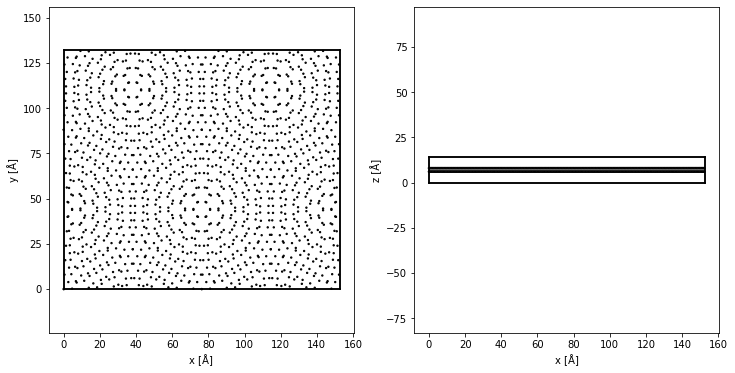

In [3]:
atoms = orthogonalize_cell(graphene_bilayer(6, 8)) * (2,1,1)

atoms.center(axis=2, vacuum=6)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
show_atoms(atoms, ax=ax1);
show_atoms(atoms, ax=ax2, plane='xz');

In [4]:
potential = Potential(atoms, sampling=.06, slice_thickness=1, device='gpu', projection='infinite',
                      parametrization='kirkland', precalculate=False)


S = SMatrix(semiangle_cutoff=10, interpolation=4, energy=80e3, device='gpu', storage='cpu')
detector = AnnularDetector(inner=90, outer=180)
gridscan = GridScan(start=[0, 0], end=potential.extent, sampling=.9*S.ctf.nyquist_sampling)

S = S.multislice(potential, pbar=True)
S = S.downsample('limit')

scans = gridscan.partition_scan((2, 2))
measurements = detector.allocate_measurement(S, gridscan)

for scan in scans:
    cropped = S.crop_to_scan(scan)
    cropped = cropped.transfer('gpu')
    cropped.scan(scan, detector, measurements=measurements, pbar=True)

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x248b7672d90>)

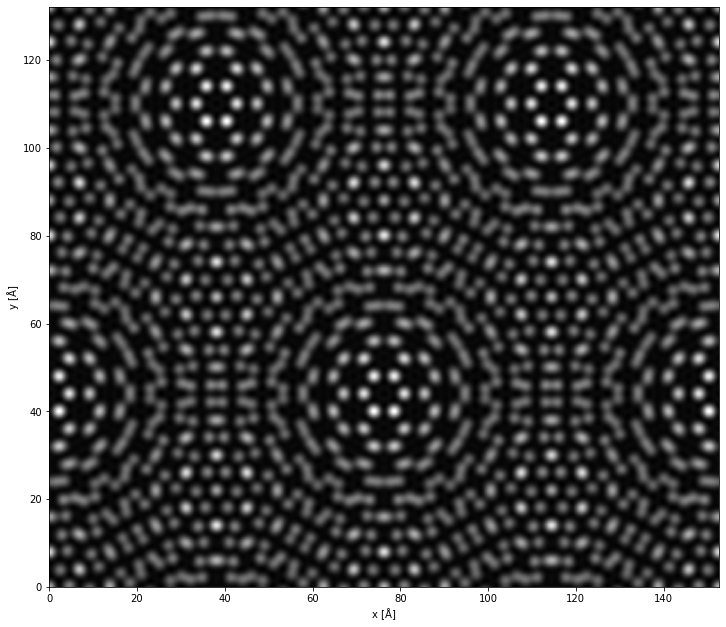

In [5]:
measurements.interpolate(.05).show(figsize=(12,12))